<a href="https://www.kaggle.com/code/davidolushola/bayessianbrest?scriptVersionId=288630100" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import pandas as pd
import os
import glob
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold
import time

In [2]:


data_file = pd.read_csv('/kaggle/input/breakhis/Folds.csv')
img_dir = ('/kaggle/input/breakhis/BreaKHis_v1')
class_names = ['benign', 'malignant']
#result = ('/content/drive/MyDrive/Hist_brest')

In [3]:
data = data_file.rename(columns={'filename':'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])
data.head()

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-004.png
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-005.png


In [4]:
# Dataset class
class BreakHisDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image path and label
        img_path = os.path.join(self.img_dir, self.data.iloc[idx]['path'])
        image = Image.open(img_path).convert("RGB")
        label = self.data.iloc[idx]['label']

        # Convert label to numeric
        if isinstance(label, str):
            label = class_names.index(label)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# DataLoader
dataset = BreakHisDataset(data, img_dir, transform=transform)

dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    #num_workers=os.cpu_count(),  #AUTOTUNE
    #pin_memory=True if device.type == "cuda" else False,
    #prefetch_factor=2
)

#sending a batch to GPU
#for images, labels in dataloader:
    #images, labels = images.to(device), labels.to(device)
   # print("Images on:", images.device)
    #print("Labels on:", labels.device)
    #break

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

Benign: 12400
Malignant: 27145


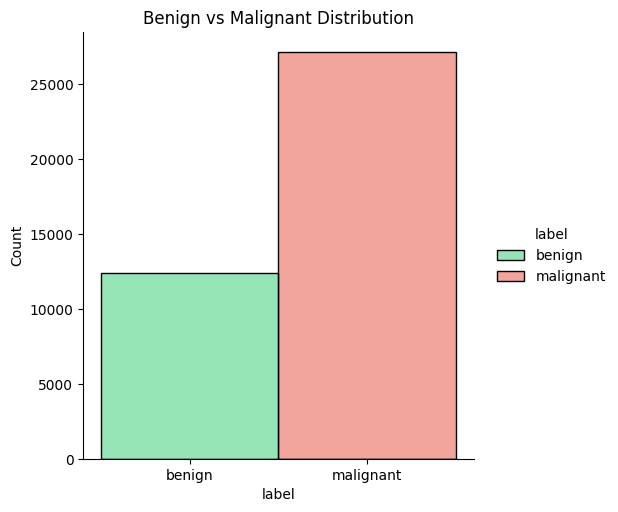

In [5]:
#check distribtion

sns.displot(data, x='label', hue='label', palette=['#2ecc71', '#e74c3c'])
print('Benign:', data[data.label == 'benign'].shape[0])
print('Malignant:', data[data.label == 'malignant'].shape[0])
plt.title('Benign vs Malignant Distribution')
plt.show()

In [6]:
# Split dataset
test_df  = data.groupby('label', group_keys=False).sample(n=300)
train_df = data.drop(test_df.index).reset_index(drop=True)
valid_df = train_df.sample(frac=0.2)
train_df = train_df.drop(valid_df.index).reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

for name, df in zip(['Training', 'Validation', 'Test'], [train_df, valid_df, test_df]):
    print(f'\n{name} set:\n', df.label.value_counts())



Training set:
 label
malignant    21439
benign        9717
Name: count, dtype: int64

Validation set:
 label
malignant    5406
benign       2383
Name: count, dtype: int64

Test set:
 label
benign       300
malignant    300
Name: count, dtype: int64


In [7]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
SAMPLE_SIZE = len(train_df)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


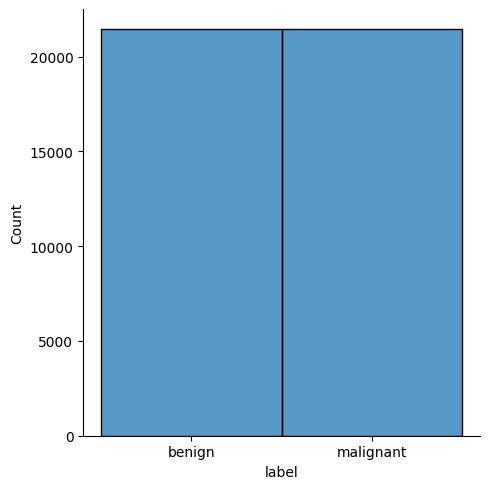

In [8]:
# upsampling instead SMOTE training dataset to avoid bias PREDICTION

max_count = np.max(train_df.label.value_counts())
min_count = np.min(train_df.label.value_counts())
train_df = train_df.groupby('label').sample(n=max_count, replace=True)
train_df = train_df.reset_index(drop=True)
train_df.label.value_counts()

ax = sns.displot(data=train_df, x='label')

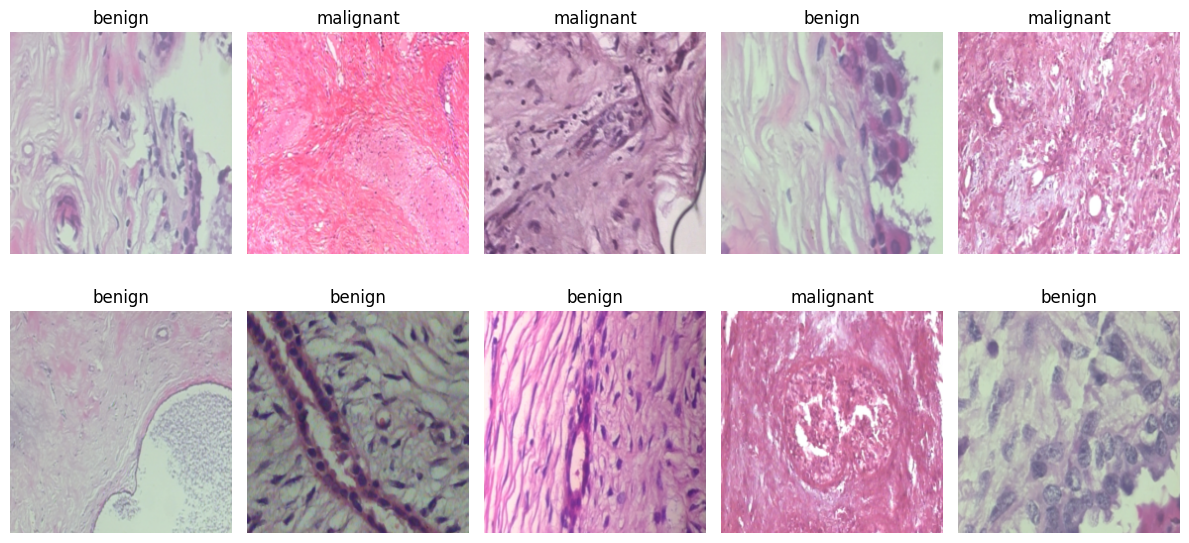

In [9]:
images, labels = next(iter(dataloader))

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(10):
    img = images[i].permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(class_names[labels[i].item()])
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [10]:
# data augumentation
from torchvision import transforms

#augmentations for training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# augmentation for validation data
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [11]:
#create dataLoader for each dataset

train_dataset = BreakHisDataset(train_df, img_dir, transform=train_transform)
valid_dataset = BreakHisDataset(valid_df, img_dir, transform=val_test_transform)
test_dataset  = BreakHisDataset(test_df,  img_dir, transform=val_test_transform)

#Dataloader with GPU
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    num_workers=os.cpu_count(), pin_memory=True, prefetch_factor=2
)

val_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=32, shuffle=False,
    num_workers=os.cpu_count(), pin_memory=True, prefetch_factor=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False,
    num_workers=os.cpu_count(), pin_memory=True, prefetch_factor=2
)

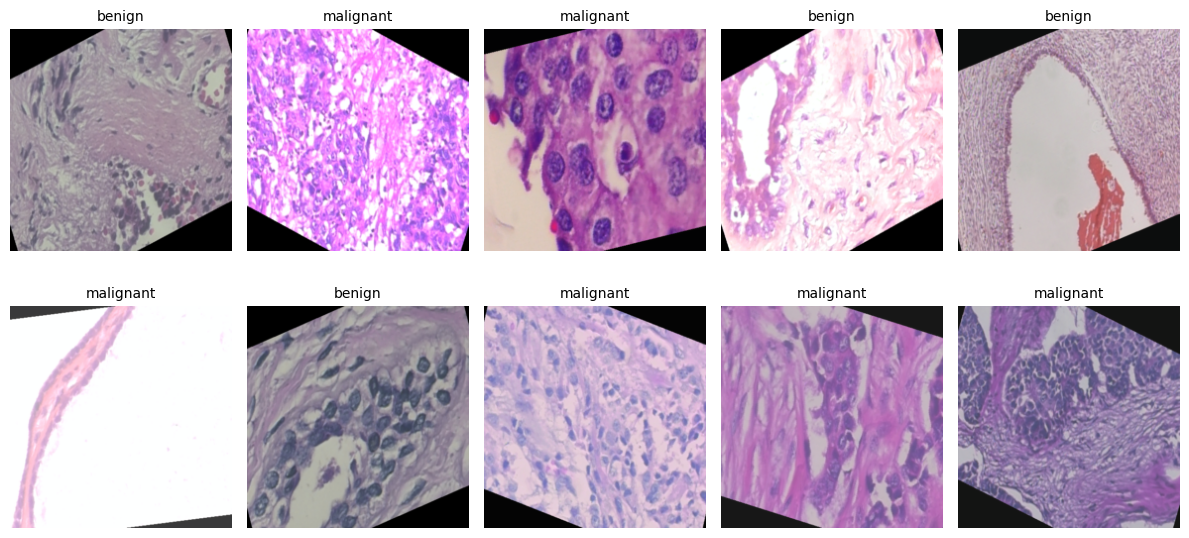

In [12]:
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = images[i].permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)
    ax.imshow(img)
    ax.set_title(f"{class_names[labels[i]]}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    preds_list = []
    labels_list = []

    for imgs, labels in tqdm(dataloader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(outputs, dim=1)
        preds_list.extend(preds.detach().cpu().tolist())
        labels_list.extend(labels.detach().cpu().tolist())

    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = accuracy_score(labels_list, preds_list)
    f1 = f1_score(labels_list, preds_list, average="macro")
    return avg_loss, accuracy, f1

def mc_predict(model, x, mc_runs=20):
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(mc_runs):
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            preds.append(probs.unsqueeze(0))
    preds = torch.cat(preds, dim=0)
    mean_pred = preds.mean(dim=0)
    epistemic_uncertainty = preds.var(dim=0)
    return mean_pred, epistemic_uncertainty

def eval_epoch(model, dataloader, criterion, mc_samples=5):
    model.train() # Important for MC Dropout inference: keep dropout active
    total_loss = 0.0
    preds_list = []
    labels_list = []

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Bayesian Evaluation", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)

            # Calculate loss from a single forward pass (dropout active)
            logits_for_loss = model(imgs)
            loss = criterion(logits_for_loss, labels)
            total_loss += loss.item() * imgs.size(0)

            # Perform MC predictions for robust class prediction
            mean_pred_probs, _ = mc_predict(model, imgs, mc_runs=mc_samples)

            preds = torch.argmax(mean_pred_probs, dim=1)
            preds_list.extend(preds.detach().cpu().tolist())
            labels_list.extend(labels.detach().cpu().tolist())

    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = accuracy_score(labels_list, preds_list)
    f1 = f1_score(labels_list, preds_list, average="macro")
    return avg_loss, accuracy, f1

In [13]:
#ResNet-50

import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

#ResNet-50

def get_baseline_model():
    model = models.resnet50(weights=None)
    num_feats = model.fc.in_features
    model.fc = nn.Linear(num_feats, 2)
    return model.to(device)

base_model = get_baseline_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-4)

Device: cuda


In [14]:
#create dataLoader for each dataset

#train_dataset = BreakHisDataset(train_df, img_dir, transform=train_transform)
#valid_dataset = BreakHisDataset(valid_df, img_dir, transform=val_test_transform)
#test_dataset  = BreakHisDataset(test_df,  img_dir, transform=val_test_transform)

#no augument
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(valid_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [15]:
#define early stopage
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
EPOCHS = 15
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    start_time = time.time()
    base_model.train()
    train_loss, train_preds, train_labels = 0.0, [], []

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = base_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.detach().cpu().tolist())
        train_labels.extend(labels.detach().cpu().tolist())

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)

    #Validation
    base_model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = base_model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.detach().cpu().tolist())
            val_labels.extend(labels.detach().cpu().tolist())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)

    #Save metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


    elapsed = time.time() - start_time
    print(f"{len(train_loader):>3}/{len(train_loader)} [==============================] "
          f"- {elapsed:.1f}s - loss: {avg_train_loss:.4f} - accuracy: {train_acc:.4f} "
          f"- val_loss: {avg_val_loss:.4f} - val_accuracy: {val_acc:.4f}")

    # Early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

672/672 [==============================] - 1189.6s - loss: 0.4904 - accuracy: 0.7688 - val_loss: 0.3645 - val_accuracy: 0.8508


672/672 [==============================] - 1141.1s - loss: 0.4313 - accuracy: 0.8061 - val_loss: 0.4235 - val_accuracy: 0.8321


672/672 [==============================] - 1148.2s - loss: 0.3854 - accuracy: 0.8330 - val_loss: 0.3531 - val_accuracy: 0.8597


672/672 [==============================] - 1141.4s - loss: 0.3525 - accuracy: 0.8506 - val_loss: 0.3474 - val_accuracy: 0.8506


672/672 [==============================] - 1126.8s - loss: 0.3287 - accuracy: 0.8628 - val_loss: 0.2621 - val_accuracy: 0.8946


672/672 [==============================] - 1134.9s - loss: 0.3065 - accuracy: 0.8713 - val_loss: 0.2482 - val_accuracy: 0.9032


672/672 [==============================] - 1140.5s - loss: 0.2888 - accuracy: 0.8788 - val_loss: 0.3236 - val_accuracy: 0.8495


672/672 [==============================] - 1138.7s - loss: 0.2731 - accuracy: 0.8845 - val_loss: 0.2088 - val_accuracy: 0.9205


Epoch 9/15:   9%|▊         | 58/672 [01:34<14:39,  1.43s/it]

In [ ]:
#accuracy Visualization

plt.figure(figsize=(10, 5))

# plot Loss5
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

def evaluate_model(model, test_loader, class_names):
    model.eval()
    test_loss = 0.0
    preds_list = []
    labels_list = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * imgs.size(0)

            preds = torch.argmax(outputs, dim=1)
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    # Averages
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_acc = accuracy_score(labels_list, preds_list)
    test_f1 = f1_score(labels_list, preds_list, average="macro")

    print("\n==================== TEST PERFORMANCE ====================")
    print(f"Test Loss      : {avg_test_loss:.4f}")
    print(f"Test Accuracy  : {test_acc:.4f}")
    print(f"Test F1-score  : {test_f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(labels_list, preds_list, target_names=class_names))

    # Confusion Matrix
    cm = np.zeros((len(class_names), len(class_names)), dtype=int)
    for t, p in zip(labels_list, preds_list):
        cm[t, p] += 1

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return avg_test_loss, test_acc, test_f1


In [ ]:
class_names = class_names
test_loss, test_acc, test_f1 = evaluate_model(base_model, test_loader, class_names)

In [ ]:
#save 

# After training is done
# Save full model
torch.save(base_model.state_dict(), "get_baseline_model.pth")
print("Model saved successfully!")

print("Saving model...")

MODEL_PATH = "resnet50_weights.pth"

torch.save({
    'model_state_dict': base_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}, MODEL_PATH)

print(f"Base_Model saved successfully at: {MODEL_PATH}")


In [ ]:

def expected_calibration_error(probs, labels, n_bins=15):
    """
    probs: numpy array of shape (N, num_classes)
    labels: numpy array of shape (N,)
    """

    # Predicted class and confidence
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)

    ece = 0.0
    bin_bounds = np.linspace(0, 1, n_bins + 1)

    for i in range(n_bins):
        start = bin_bounds[i]
        end = bin_bounds[i + 1]

        # Bin mask
        mask = (confidences >= start) & (confidences < end)
        bin_size = np.sum(mask)

        if bin_size > 0:
            bin_conf = np.mean(confidences[mask])
            bin_acc = np.mean(predictions[mask] == labels[mask])
            ece += (bin_size / len(labels)) * abs(bin_acc - bin_conf)

    return ece

In [ ]:

all_probs = []
all_labels = []

base_model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = base_model(x)
        probs = torch.softmax(logits, dim=1)

        all_probs.append(probs.cpu())
        all_labels.append(y.cpu())

# Convert to numpy arrays
all_probs = torch.cat(all_probs).numpy()        # shape (N, num_classes)
all_labels = torch.cat(all_labels).numpy()      # shape (N,)



In [ ]:

baseline_ECE = expected_calibration_error(all_probs, all_labels)
print("Baseline ResNet50 ECE:", baseline_ECE)


In [ ]:
# 2. Brier Score (multi-class)
y_true_onehot = np.eye(all_probs.shape[1])[all_labels]
brier = np.mean(np.sum((all_probs - y_true_onehot)**2, axis=1))
print("Baseline Brier Score:", brier)



In [ ]:
# 3. Negative Log Likelihood
nll = log_loss(all_labels, all_probs)
print("Baseline NLL:", nll)




In [ ]:
# 4. Confidence Histogram
plt.hist(np.max(all_probs, axis=1), bins=20)
plt.title("Baseline ResNet Confidence Histogram")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()



**Bayesian Deep Learning (MC Dropout)**

In [16]:
class BayesianResNet50(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()

        # USE PRETRAINED WEIGHTS FOR FASTER TRAINING
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        num_feats = self.model.fc.in_features

        # Insert MC-Dropout
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_feats, 2)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bayes_model = BayesianResNet50(dropout_rate=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bayes_model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s] 


***Bayessian Training loop***

In [17]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
EPOCHS = 15
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    start_time = time.time()
    bayes_model.train()

    train_loss, train_preds, train_labels = 0.0, [], []

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = bayes_model(imgs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.detach().cpu().tolist())
        train_labels.extend(labels.detach().cpu().tolist())

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)
    
    # validation
    bayes_model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = bayes_model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.detach().cpu().tolist())
            val_labels.extend(labels.detach().cpu().tolist())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    elapsed = time.time() - start_time

    print(f"{len(train_loader):>3}/{len(train_loader)} [==============================] "
          f"- {elapsed:.1f}s - loss: {avg_train_loss:.4f} - accuracy: {train_acc:.4f} "
          f"- val_loss: {avg_val_loss:.4f} - val_accuracy: {val_acc:.4f}")

    # EARLY STOPPING
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break


670/670 [==============================] - 1251.8s - loss: 0.1435 - accuracy: 0.9435 - val_loss: 0.1790 - val_accuracy: 0.9475


Epoch 3/15:  97%|█████████▋| 653/670 [18:23<00:31,  1.84s/it]

In [ ]:
#accuracy Visualization

plt.figure(figsize=(10, 5))

# plot Loss5
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(bayes_model, test_loader, class_names):
    bayes_model.eval()
    test_loss = 0.0
    preds_list = []
    labels_list = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = bayes_model(imgs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * imgs.size(0)

            preds = torch.argmax(outputs, dim=1)
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    # Averages
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_acc = accuracy_score(labels_list, preds_list)
    test_f1 = f1_score(labels_list, preds_list, average="macro")

    print("\n==================== TEST PERFORMANCE ====================")
    print(f"Test Loss      : {avg_test_loss:.4f}")
    print(f"Test Accuracy  : {test_acc:.4f}")
    print(f"Test F1-score  : {test_f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(labels_list, preds_list, target_names=class_names))

# Confusion Matrix
    cm = np.zeros((len(class_names), len(class_names)), dtype=int)
    for t, p in zip(labels_list, preds_list):
        cm[t, p] += 1

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return avg_test_loss, test_acc, test_f1


In [ ]:
class_names = class_names
test_loss, test_acc, test_f1 = evaluate_model(bayes_model, test_loader, class_names)

In [ ]:
def enable_mc_dropout(bayes_model):
    """Activate dropout in eval mode."""
    for m in bayes_model.modules():
        if isinstance(m, nn.Dropout):
            m.train()


In [ ]:
import torch.nn.functional as F
import numpy as np

def mc_predict(bayes_model, x, T=20):
    bayes_model.eval()
    enable_mc_dropout(bayes_model)

    preds = []
    with torch.no_grad():
        for _ in range(T):
            out = bayes_model(x)
            prob = F.softmax(out, dim=1)
            preds.append(prob.cpu().numpy())

    preds = np.array(preds)   # shape (T, batch, 2)

    mean_pred = preds.mean(axis=0)           # predictive mean
    uncertainty = preds.var(axis=0).mean()   # predictive uncertainty

    return mean_pred, uncertainty


In [ ]:
bayes_model.eval()
uncertainties = []
true_labels = []
pred_labels = []

for imgs, labels in val_loader:
    imgs = imgs.to(device)
    labels = labels.numpy()

    mean_pred, unc = mc_predict(bayes_model, imgs, T=30)
    preds = np.argmax(mean_pred, axis=1) 

    uncertainties.append(unc)
    true_labels.extend(labels)
    pred_labels.extend(preds)


In [ ]:
# Convert to numpy arrays
true_labels = np.array(true_labels)
mean_pred = np.array(mean_pred)

print("Accuracy:", accuracy_score(true_labels, pred_labels))
print("F1 Score:", f1_score(true_labels, pred_labels))

In [ ]:
all_probs = np.concatenate(all_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


In [ ]:
def expected_calibration_error(probs, labels, bins=15):

    confidences = np.max(probs, axis=1)
    preds = np.argmax(probs, axis=1)

    bin_boundaries = np.linspace(0, 1, bins+1)
    ece = 0.0

    for i in range(bins):
        mask = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i+1])
        
        if mask.sum() > 0:
            acc = np.mean(preds[mask] == labels[mask])
            conf = np.mean(confidences[mask])
            ece += np.abs(acc - conf) * (mask.sum() / len(labels))

    return ece


In [ ]:
ECE = expected_calibration_error(all_probs, all_labels)
print("ECE:", ECE)